In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

### load already prepared datasets using pickle

In [27]:
d = pickle.load(open("./results/dataset_scaled.p", "rb"))
X = d["X"]
Y = d["Y"]
#Y = d["Y_initial"]

input_shape = [X.shape[-1]]
y_shape = Y.shape[-1]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.75, shuffle=True)

/home/laptop/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### create a baseline model
we have three hidden layers and one output layer with the number of neurons as the number of corrector magnets

In [28]:
model_base = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=input_shape),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),    
    layers.Dense(y_shape)
])

model_base.compile(
    optimizer='adam',
    loss='mse'
)

early_stopping = EarlyStopping(
    patience = 50,
    min_delta=0.001,
    restore_best_weights=True
)

In [29]:
history_base = model_base.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    batch_size=256,
    epochs=128,
    callbacks = [early_stopping],
    verbose=False
)

### Try batch normalization in cross-validation and dropout

In [30]:
model_cv = keras.Sequential([
    #layers.BatchNormalization(input_shape=input_shape),  # it normalizes the whole input
    layers.Dense(1024, activation='relu', input_shape=input_shape),
    layers.Dropout(0.3),

    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.1),
    
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.1),
    
    layers.Dense(y_shape)
])

model_cv.compile(
    optimizer='adam',
    loss='mse'
)

early_stopping = EarlyStopping(
    patience = 50,
    min_delta=0.001,
    restore_best_weights=True
)

In [31]:
history = model_cv.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    batch_size=256,
    epochs=128,
    callbacks = [early_stopping],
    verbose=False
)

### compare to simple models
though we have less overfitting with the dropout, the score is not pushed down

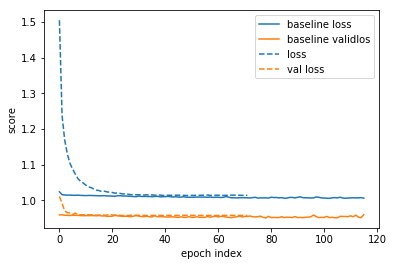

In [32]:
history_df_base = pd.DataFrame(history_base.history)
history_df = pd.DataFrame(history.history)

plt.plot(history_df_base["loss"], label="baseline loss")
plt.plot(history_df_base["val_loss"], label="baseline validlos")

plt.plot(history_df["loss"], c="C0", ls="--", label='loss')
plt.plot(history_df["val_loss"], c="C1", ls="--", label='val loss')

plt.xlabel("epoch index")
plt.ylabel("score")

plt.legend()
#plt.ylim(0,0.1)

### Trying with pre-defined corrector clusters

In [78]:
d = pickle.load(open("./results/dataset_clustered.p", "rb"))
X = d["X"]
Y = d["Y"]
#Y = d["Y_initial"]

input_shape = [X.shape[-1]]
y_shape = Y.shape[-1]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.75, shuffle=True)

In [79]:
model = keras.Sequential([
    #layers.BatchNormalization(input_shape=input_shape),  # it normalizes the whole input
    layers.Dense(512, activation='relu', input_shape=input_shape),
    layers.Dropout(0.2),

    #layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.1),
    
    #layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),

    #layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),
    
    layers.Dense(y_shape)
])

model.compile(
    optimizer='adam',
    loss='mse'
)

early_stopping = EarlyStopping(
    patience = 50,
    min_delta=0.001,
    restore_best_weights=True
)

In [80]:
history1 = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    batch_size=256,
    epochs=512,
    callbacks = [early_stopping],
    verbose=False
)

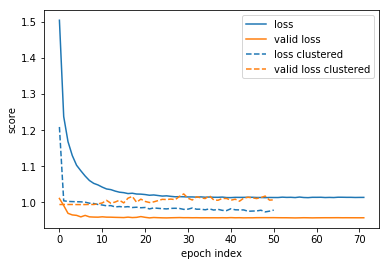

In [81]:
history_df1 = pd.DataFrame(history1.history)

plt.plot(history_df['loss'], c="C0", label="loss")
plt.plot(history_df['val_loss'], c="C1", label="valid loss")
plt.plot(history_df1['loss'], c="C0",ls="--", label="loss clustered")
plt.plot(history_df1['val_loss'], c="C1",ls="--", label="valid loss clustered")

#plt.ylim(0.02,0.1)
plt.xlabel("epoch index")
plt.ylabel("score")

plt.legend()

## Validation on test data

In [82]:
from correction import *

In [83]:
def prepare_test_data(stopband0, twiss):
    
    df = pd.DataFrame()

    df['stopband_initial'] = [np.mean(stopband0)] 

    bpmx = twiss[twiss["keyword"].str.contains("hmonitor")][["name", "betx"]]
    bpmy = twiss[twiss["keyword"].str.contains("vmonitor")][["name", "bety"]]

    for name, beta in zip(bpmx["name"], bpmx["betx"]):
        df[name[:-2]] = [beta]

    for name, beta in zip(bpmy["name"], bpmy["bety"]):
        df[name[:-2]] = [beta]
        
    return df

In [84]:
Qx, Qy = 18.75, 18.8
dk = 1e-3

madx = Madx(stdout=False)
twiss, twiss_cold_arr = lattice_setup(Qx,Qy, madx)
twiss_err = add_quadrupole_errors(twiss, dk, madx, 0, store_errors=False)

theta = np.zeros(24)
stopband0 = find_stopband(theta, twiss_cold_arr, madx)

df = prepare_test_data(stopband0, twiss)

### transform test data

In [85]:
features = [name for name in X.columns.tolist() if "median" not in name and "Cluster" not in name]

X_test = df[features]
X_test_scaled = d['scaler_x'].transform(X_test)

### get clusters

In [91]:
kmeans = d["kmeans"]
cluster = kmeans.predict(X_test_scaled)[0]

median_features = [name for name in X.columns.tolist() if "median" in name]
Y_pred = np.array(X[X['Cluster'] == cluster][median_features].mean())

Y_pred = d['scaler_y'].transform(Y_pred.reshape(1, -1))[0]

In [92]:
Y_pred

array([-0.00830272,  0.02711693, -0.16871844, -0.09507183, -0.0174528 ,
       -0.00926064,  0.01812502,  0.00375345, -0.00446289, -0.01469417,
       -0.19778815, -0.08729046, -0.04701239,  0.02417986, -0.04698497,
       -0.01120743, -0.03167005, -0.01973968, -0.00692111,  0.03002619,
       -0.02906902,  0.00532026, -0.05347498,  0.00545894])

In [93]:
madx.input(matching(Qx, Qy))
qx,qy = set_quads(Y_pred, madx)
print(f"tunes are {qx} {qy}")
twiss_cluster = madx.table.twiss.dframe()

AttributeError: q1

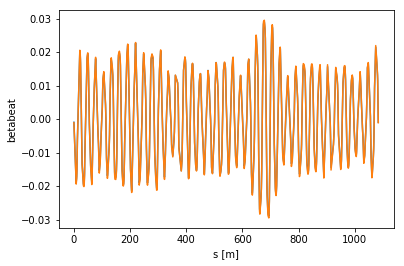

In [89]:
plt.plot(twiss_err['s'], twiss_err['bety'] / twiss['bety'] - 1)
plt.plot(twiss_cluster['s'], twiss_cluster['bety'] / twiss['bety'] - 1)

#plt.xlim(0, 1083.6 / 3)

plt.xlabel("s [m]")
plt.ylabel("betabeat")

plt.show();

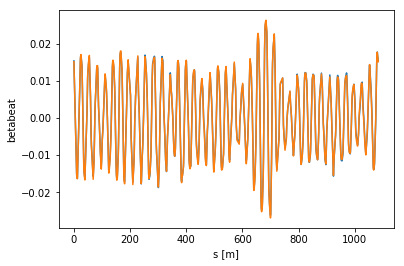

In [90]:
plt.plot(twiss_err['s'], twiss_err['betx'] / twiss['betx'] - 1)
plt.plot(twiss_cluster['s'], twiss_cluster['betx'] / twiss['betx'] - 1)

#plt.xlim(0, 1083.6 / 3)

plt.xlabel("s [m]")
plt.ylabel("betabeat")

plt.show();

### network model validation

In [71]:
d = pickle.load(open("./results/dataset_scaled.p", "rb"))
X_test_scaled = d['scaler_x'].transform(X_test)

Y_pred_base = model_base.predict(X_test_scaled)[0]
Y_pred_base = d['scaler_y'].transform(Y_pred_base.reshape(1,-1))[0] / 1000

In [72]:
Y_pred_base

array([ 3.7994589e-05,  1.6134167e-04, -3.2078828e-05, -5.3571915e-04,
       -3.2169421e-04, -3.1322867e-04, -3.1395841e-05, -8.1438295e-05,
       -1.6215334e-05, -8.2981906e-06, -6.4876345e-05, -2.0172748e-04,
       -1.0534173e-05,  1.6394434e-06, -1.9398458e-05, -2.4723752e-07,
       -2.0907934e-05, -1.0586839e-05,  3.1287324e-05,  3.3506745e-05,
       -1.7100247e-05, -8.8153383e-06, -4.9330338e-05,  2.4404575e-05],
      dtype=float32)

In [73]:
madx.input(matching(Qx, Qy))
qx,qy = set_quads(Y_pred_base, madx)
print(f"tunes are {qx} {qy}")
twiss_base = madx.table.twiss.dframe()

tunes are 18.749999942070566 18.79999999179937


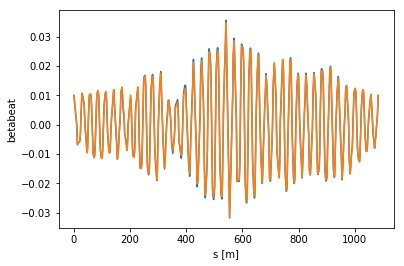

In [74]:
plt.plot(twiss_err['s'], twiss_err['bety'] / twiss['bety'] - 1)
plt.plot(twiss_base['s'], twiss_base['bety'] / twiss['bety'] - 1)

#plt.xlim(0, 1083.6 / 3)

plt.xlabel("s [m]")
plt.ylabel("betabeat")

plt.show();

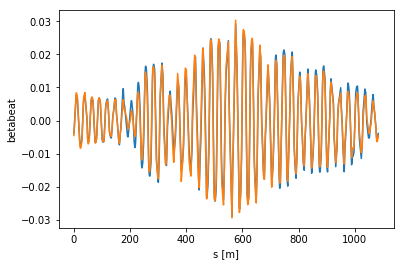

In [76]:
plt.plot(twiss_err['s'], twiss_err['betx'] / twiss['betx'] - 1)
plt.plot(twiss_base['s'], twiss_base['betx'] / twiss['betx'] - 1)

#plt.xlim(0, 1083.6 / 3)

plt.xlabel("s [m]")
plt.ylabel("betabeat")

plt.show();